In [1]:
%matplotlib inline

import sys

sys.path.append('..')

import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
from datetime import datetime
import os
import matplotlib.pyplot as plt
from open_ocean.utils import convert_climatology_to_ocean_areas
import open_ocean.gridder as gridder
import open_ocean.interpolation as io

In [2]:
def convert_dates(months, days):
    return [datetime(2020, months[i], days[i]) for i in range(len(months))]

In [3]:
data_dir = Path(os.getenv("OODIR"))
coder = xr.coders.CFDatetimeCoder(time_unit="s")

Interpolation
=============

As a first pass on the interpolation, I'm going to use a basic Gaussian Process. I will treat the grid cell centres as the locations of the observations and the grid cell averages as the observation values. In principle, we could go straight from the individual observations to a gridded representation, but doing it this way means I can make use of the observational error covariances while keeping the computational costs reasonable. I'm running this on my desktop machine which isn't especially powerful. It's no slouch, but when I've run this kind of thing before I've had access to a large amount of processing. So. I'm trying to keep it simple.

Kriging and Gaussian Processes on a globe can be a bit of a pain because most of the standard routines assume your domain is not curved. Our observations are points on the surface of a sphere specified by latitudes and longitudes. We could treat these as x and y in a 2D space, but this can cause numerical problems when we start to build covariance matrices and calculate distances between them. One solution, or so I'm told, is to convert latitudes and longitudes to their three cartesian coordinates and do the GP in 3D. This is easy to do, so that's what I did.

To further simplify my task, I used some default values for the Gaussian Process, which I suspect will work quite well (they worked fine for HadCRUT5). I calculate the Matern covariance between points using a length scale of 1300km, a variance of 0.6K, and with a shape factor of 1.5, which is intermediate between a simple exponential and a gaussian. It's a sharp gaussian, or a blunt exponential. The results of this kind of interpolation are a little blobby for my liking, so I've thrown something random into the mix: I stretch the z-coordinate by a factor of 3 which has the effect of making the resolved features more zonal i.e. they stretch further east to west than they do north to south.

In [4]:
climatology = xr.open_dataset(data_dir / "SST_CCI_climatology" / "SST_1x1_daily.nc")
areas = convert_climatology_to_ocean_areas(climatology)
sampling_unc = xr.open_dataset(data_dir / "IQUAM" / "OutputData" / "sampling_uncertainty.nc")


In [5]:
year = 1983
month = 6

file = data_dir / 'IQUAM' / f'{year}{month:02d}-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'

iquam = xr.open_dataset(file, decode_timedelta=coder)
quality = iquam.quality_level.values
selection = (quality >= 4)

id = iquam.platform_id.values[selection]
type = iquam.platform_type.values[selection]
lats = iquam.lat.values[selection]
lons = iquam.lon.values[selection]
values = iquam.sst.values[selection]

# Convert dates
dates = convert_dates(
    iquam.month.values[selection].astype(int),
    iquam.day.values[selection].astype(int)
)

# Grid up the data
grid = gridder.Grid(2020, 10, id, lats, lons, dates, values, type, climatology)
grid.add_sampling_uncertainties(sampling_unc)
grid.do_1x1_gridding()
grid.do_one_step_5x5_gridding()
grid.calculate_covariance()

That builds the basic grid from data for June 1983. At the moment, it looks like this, with an El Nino hanging around in the Pacific, but we can also see gaps, over the Southern Ocean, amongst other places. There are very few observations south of 50S and some noisiniess in the fields.

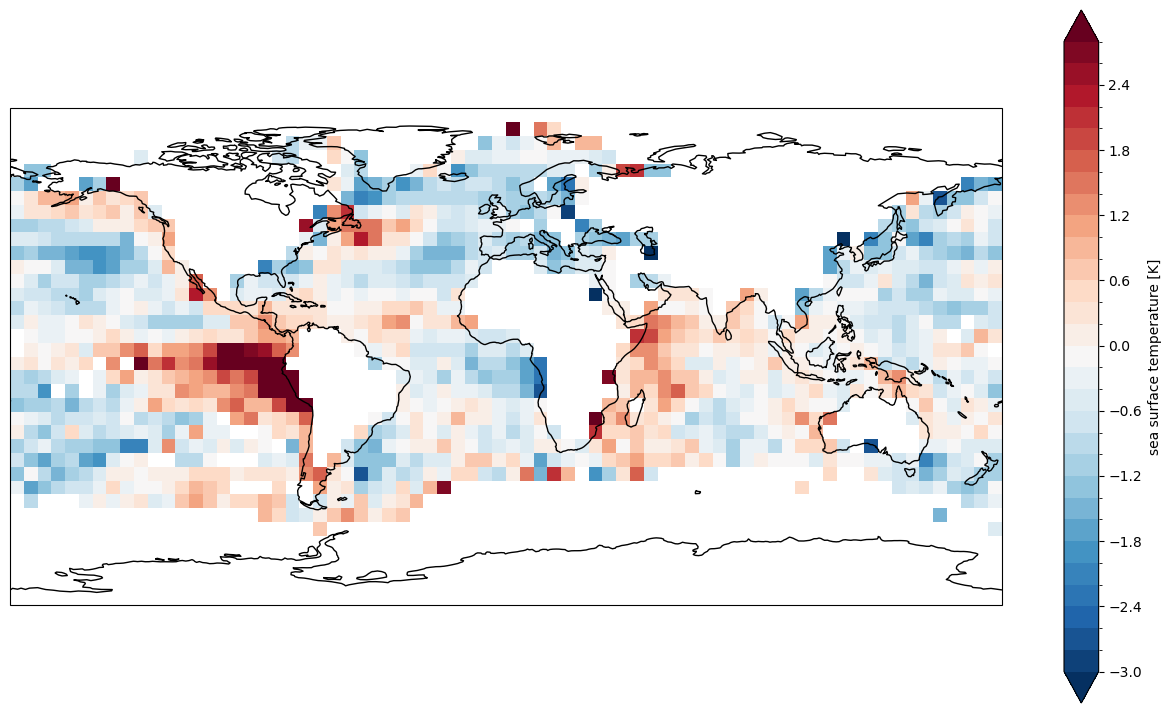

In [6]:
grid.plot_map_5x5()

In [7]:
# Set up the interpolation
kernel = io.Kernel(0.6, 1300.0,1.5)
interp = io.GPInterpolator(grid, kernel)
interp.make_covariance(constant=0.2)

C:\Users\johnk\PycharmProjects\open-ocean\open_ocean\interpolation.py:37: RuntimeWarning: invalid value encountered in multiply
  (self.variance ** 2) *


The kernel specifies the covariance kernel - a Matern Covariance as mentioned above with a variance of 0.6K, length scale of 1300 km and a shape factor of 1.5. In addition to this, I add a constant to the covariance matrix, which is a placeholder for some kind of global mean. We should have enough data here that the global mean will be well constrained.

Then we run the interpolation

In [8]:

interpolated_grid = interp.do_interpolation()
interpolated_grid.data5[np.isnan(sampling_unc.sst.values[0:1,:,:])] = np.nan

Don't worry about the RuntimeWarning. The calculation of the covariances involves multiplying zero and infinity at zero separation. The answer, it turns out, is 1 and that is what I use to fill what would otherwise be gaps in the covariance matrix.

In comparison to the input gridded observations, the map (below) of interpolated anomalies is much "smoother". Many of the larger isolated anomalies have gone (though you can still see their residual effect on the fields in places). In contrast, the clump of large positive anomalies in the eastern Tropic Pacific is still there. The individual observations corroborate and reinforce each other (in a sense). The large gaps over the Arctic and Antarctic have been filled, but I'm not sure to what extent we ought to believe them. Past a certain point "inter"polation becomes "extra"polation and it's ususally a sign to be careful.

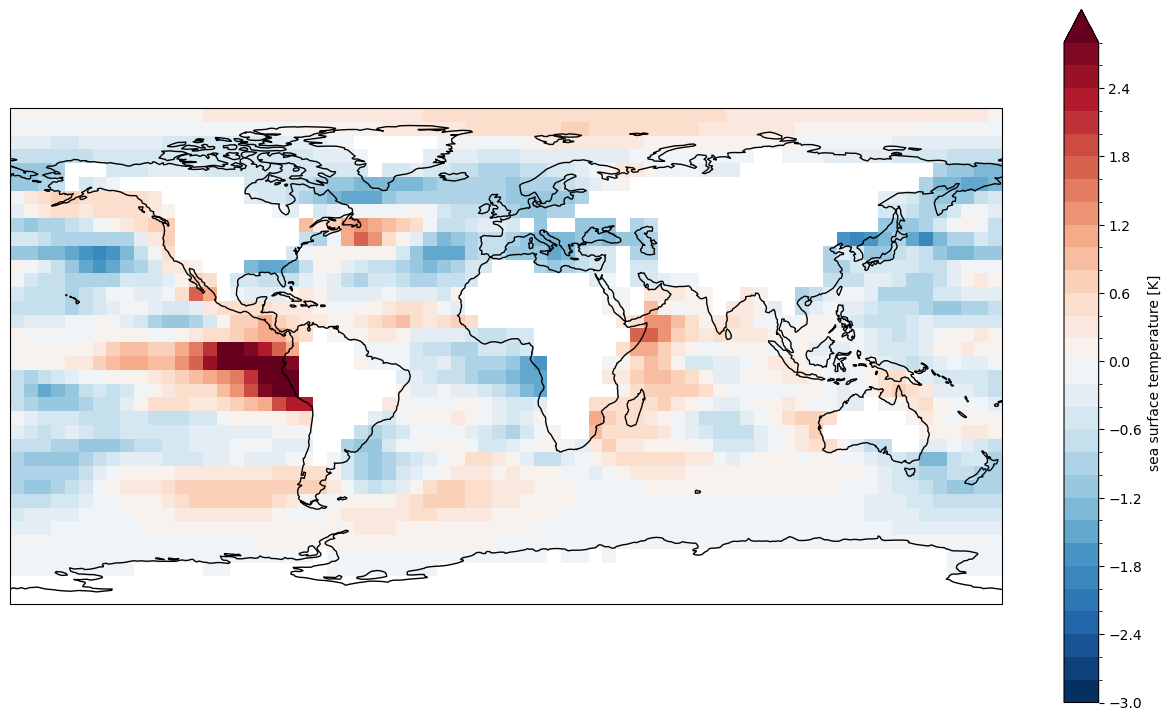

In [9]:
interpolated_grid.plot_map_5x5()

Taking the difference between the two can be interesting. In this case, the difference field is largely small scale noise, which is consistent with the idea that the observed values are a combination of the actual SST field and noise in the form of observational errors. The noise is largest at the periphery of the observed fields where there are fewer observations.

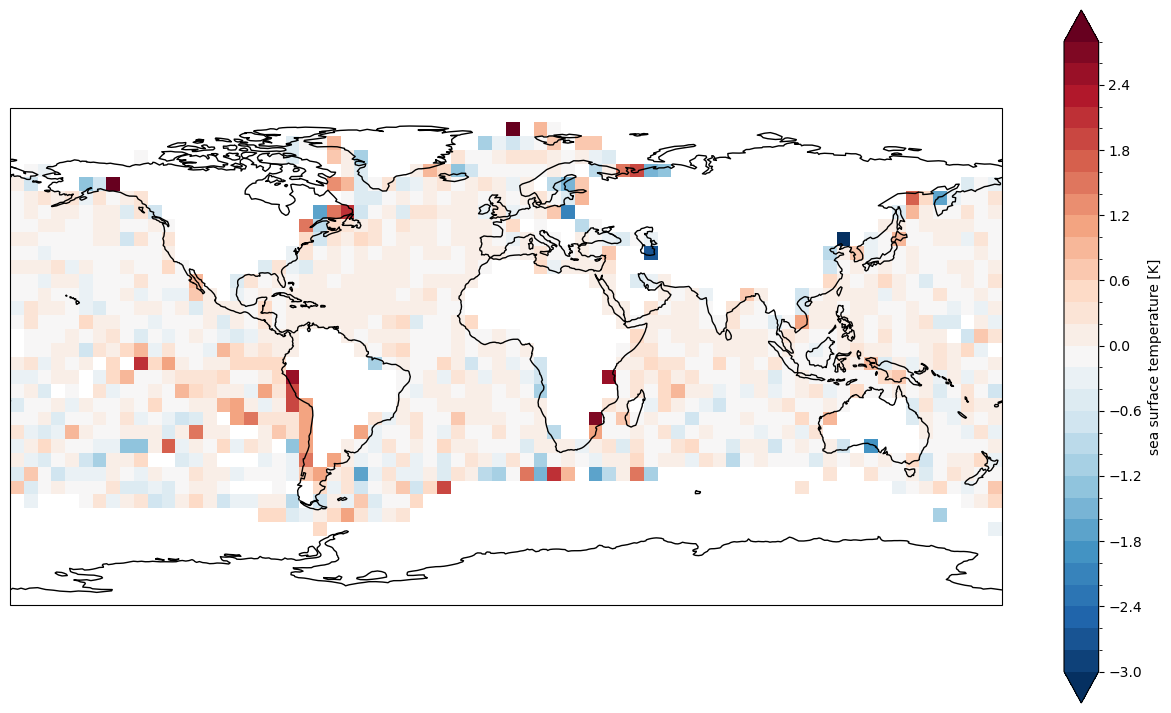

In [10]:
difference = grid - interpolated_grid
difference.plot_map_5x5()

We can also look at the covariances. The observational error covariance looks like this.

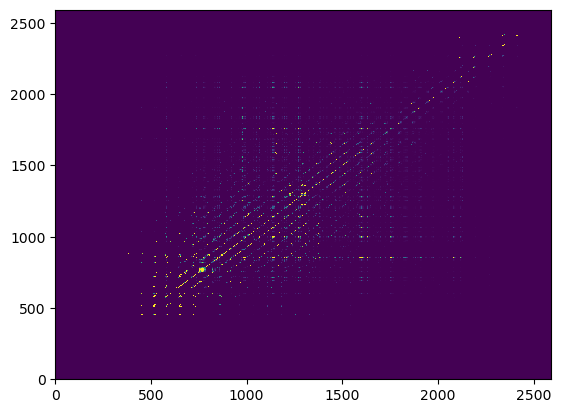

In [11]:
plt.pcolormesh(grid.covariance, vmin=0, vmax=0.03, cmap='viridis')

The covariances aren't necessarily very easy to read. The x and y axes correspond to the 2592 gridcells in the 36 by 72 grid, which has been flattened into a one dimensional array. The grid is flattened such that the first 72 elements are the southernmost edge of the map (Antarctica) starting at 180 degrees W. The next 72 elements skip back from 180E to 180W and up 5 degrees to the row of grid cells centred on 82.5 degree S.

That's probably not very helpful. If we zoom in to a small segment you can see that this leads to a block structure.

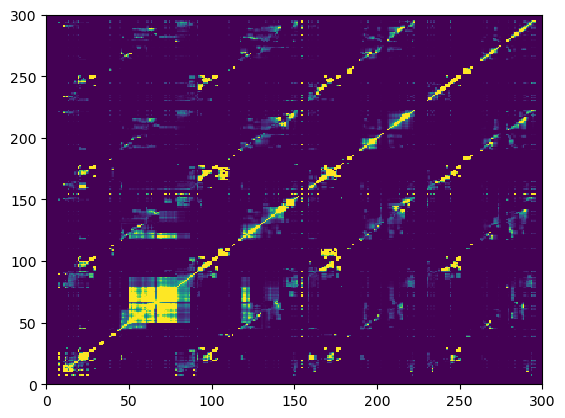

In [12]:
plt.pcolormesh(grid.covariance[700:1000,700:1000], vmin=0, vmax=0.03, cmap='viridis')

In contrast, the covariance used for the interpolation looks like this

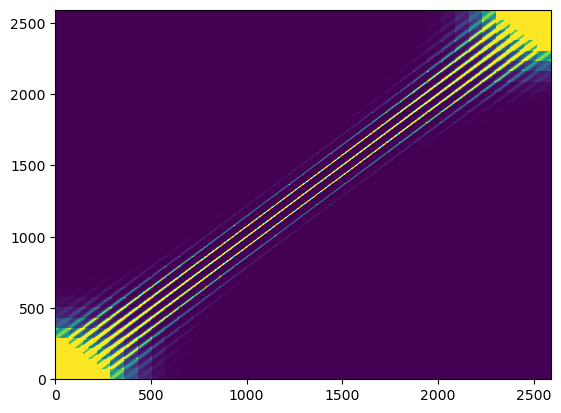

In [13]:
plt.pcolormesh(interp.cov, vmin=0.04, vmax=0.1, cmap='viridis')

The distinctive parallel bars, indicate the local nature of the interpolation covariance, which decays away to zero as you move from the diagonal, until we come round to the same point on the next latitude band. The difference in shape between the two is what allows the interpolation method to differentiate effectively between noise and actual variability though the two can be aligned locally.

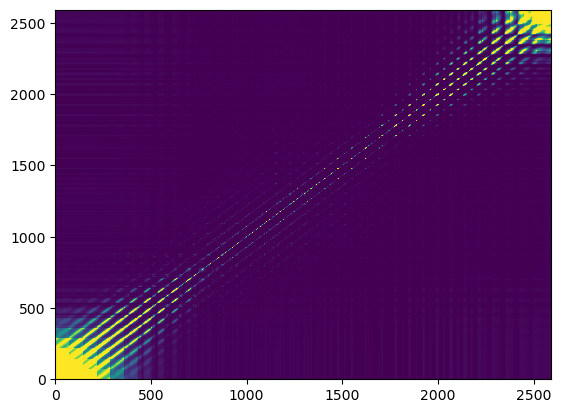

In [14]:
plt.pcolormesh(interp.posterior, vmin=0.0, vmax=0.1, cmap='viridis')

Finally, we have the posterior covariance from the reconstruction.

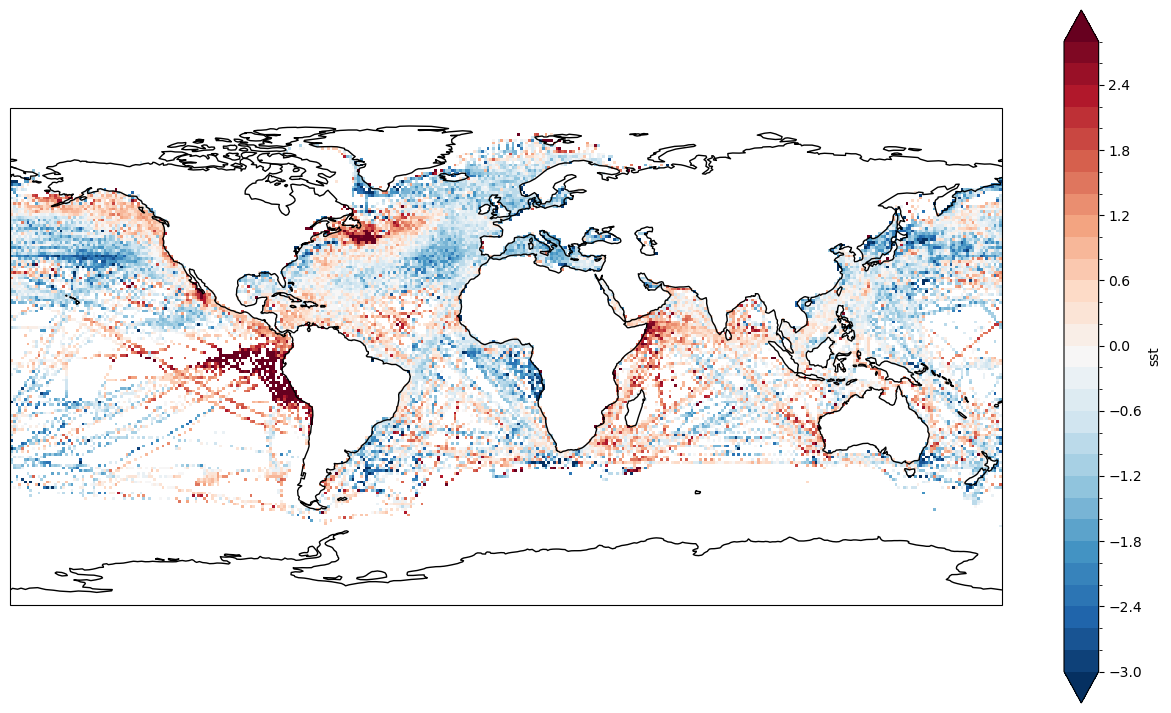

In [15]:
grid.plot_map_1x1()